# The goal is to generate a script to normalize our Sq measurements

Objective: ere I want to output the surface area of the curved plan objects fall into 

Results: this attempt failed in the Sq/area output resulted in large temporal discrepancies as more regions of unrelated FLM membrane features increased the search area (X,Y). This exercise did allow for an method to output artificial models from vertice coordinates.

In [ ]:
from chimerax.color_key import show_key
from chimerax.core import colors
from chimerax.core.commands import (BoolArg, Bounded, CmdDesc, ColormapArg,
                                    ColormapRangeArg, Int2Arg, IntArg,
                                    SurfacesArg)
from chimerax.core.commands.cli import EnumOf
from chimerax.surface import (surface_area, vertex_convexity)
from chimerax.map.volumecommand import volume
from numpy import (arccos, array, full, inf, isnan, mean, nan, nanmax, nanmean,
                   nanmin, pi, ravel_multi_index, sign, split, sqrt, subtract,
                   swapaxes, savetxt, column_stack,nansum, count_nonzero, nanstd)
from scipy.ndimage import (binary_dilation, binary_erosion,
                           generate_binary_structure, iterate_structure)
from scipy.spatial import KDTree
import numpy
import scipy
import matplotlib.pyplot as plt

In [ ]:
s= session
m= s.models
surface=m[1]
to_cell=m[3]
radius= 8
metric='RPD'
target ='sRBC'
size=(.1028,.1028,.1028)
palette=None
color_range= None
key=False
volume(session, voxel_size= size)
if target == 'sRBC':
            target_r = 2.25
elif target =='mRBC':
            target_r = 3

In [ ]:
"""Define the target centroid from mid range x,y and z coordinates."""
centroid = mean(to_cell.vertices, axis=0)

"""Vertice x,y and z distances from centroid"""
x_coord, y_coord, z_coord = split(subtract(surface.vertices, centroid), 3, 1)

x_coord = x_coord.flatten()
y_coord = y_coord.flatten()
z_coord = z_coord.flatten()
"""Converting the cartisian system into spherical coordinates"""
z_squared = z_coord ** 2
y_squared = y_coord ** 2
x_squared = x_coord ** 2

distance = sqrt(z_squared + y_squared + x_squared)
distxy = sqrt(x_squared + y_squared)
theta = sign(y_coord)*arccos(x_coord / distxy)
phi = arccos(z_coord / distance)

"""Logic to identify vertices in the targets local (defined by radius input) around target's upper hemisphere"""
abovePhi = phi <= (pi/2)
radialClose = (distance  < radius) & (distance > target_r)

"""Outputs for coloring vertices as surface. arguments"""
radialDistanceAbovePhiLimitxy = abovePhi * radialClose * distance
surface.radialDistanceAbovePhiNoNans= abovePhi * radialClose * distance 
radialDistanceAbovePhiLimitxy[radialDistanceAbovePhiLimitxy == 0] = nan

surface.radialDistanceAbovePhi= abovePhi* distance
surface.radialDistanceAbovePhiLimitxy=radialDistanceAbovePhiLimitxy

surface.radialDistance = distance
surface.theta = theta
surface.phi = phi

"""Logic to identify vertices in the targets local (defined by radius input) around target's upper hemisphere"""
abovePhi = phi <= (pi/2)
radialClose = (distance  < radius) & (distance > target_r)

"""Single value outputs for definning topology"""
surface.IRDFCarray = nanmean(radialDistanceAbovePhiLimitxy)
surface.Sum = nansum(radialDistanceAbovePhiLimitxy)
""" surface.area = surface_area(vertices, triangles) """

surface.area = count_nonzero(surface.radialDistanceAbovePhiNoNans)
surface.ArealRoughness = sqrt(surface.IRDFCarray**2/(2*pi*target_r**2))
surface.ArealRoughness_STD = nanstd(surface.radialDistanceAbovePhiLimitxy)/(2*pi*target_r**2)

In [ ]:
"""    elif metric == 'rpd' and hasattr(surface, 'radialDistanceAbovePhiNoNans'):"""
measurement = surface.radialDistanceAbovePhiNoNans
palette_string = 'purples'
max_range = 10

In [ ]:
if isnan(measurement).all():
    measurement[:] = 0

if palette is None:
    palette = colors.BuiltinColormaps[palette_string]

if color_range is not None and color_range != 'full':
    rmin, rmax = color_range
elif color_range == 'full':
    rmin, rmax = nanmin(measurement), nanmax(measurement)
else:
    rmin, rmax = (0, max_range)

In [ ]:
cmap = palette.rescale_range(rmin, rmax)
surface.vertex_colors = cmap.interpolated_rgba8(measurement)

Objects in the search 8um radius hemisphere search are paletted in purple.

![Screenshot 2023-07-02 194054.jpg](<attachment:Screenshot 2023-07-02 194054.jpg>)
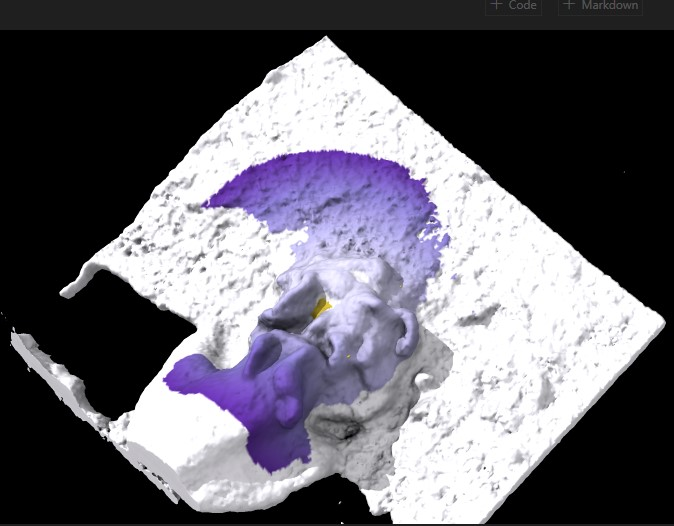

Will need to solve a way to make a 2d mask of the search area and solve for the search area.

In [ ]:
test = numpy.zeros((128,128))
test[50:100,50:100]=1

from scipy.ndimage import gaussian_laplace as gl
edge=gl(test,sigma=1)
e=edge*edge[::]>0
'set to current working directory. change path as needed'
numpy.savetxt('testEdgeFinding.txt',e,delimiter=',')


plt.imshow(test, cmap='binary')
plt.imshow(e, cmap='Greens',alpha=.5)
plt.title('Edge finding-50xSq, 128x128 Region sigma=1')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.legend()
plt.show()

![Screenshot 2023-07-02 194430.jpg](<attachment:Screenshot 2023-07-02 194430.jpg>) ![Screenshot 2023-07-02 194314.jpg](<attachment:Screenshot 2023-07-02 194314.jpg>) ![Screenshot 2023-07-02 194326.jpg](<attachment:Screenshot 2023-07-02 194326.jpg>) ![Screenshot 2023-07-02 194340.jpg](<attachment:Screenshot 2023-07-02 194340.jpg>) ![Screenshot 2023-07-02 194406.jpg](<attachment:Screenshot 2023-07-02 194406.jpg>)
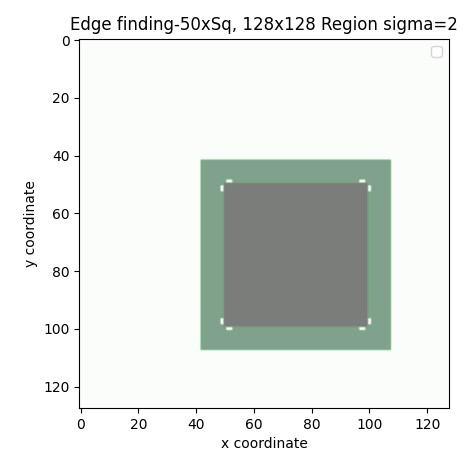
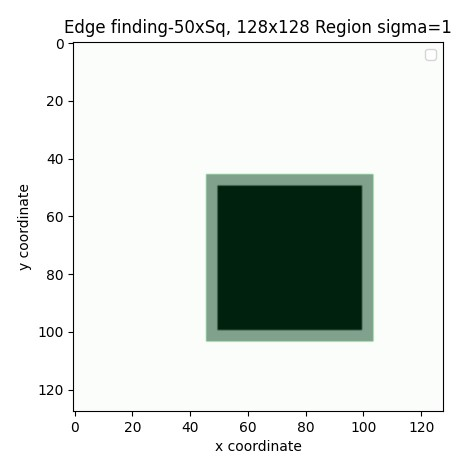
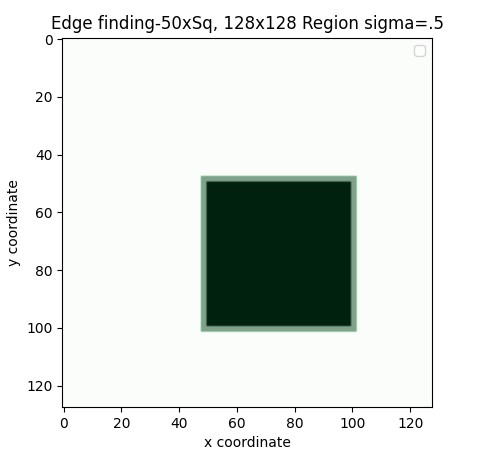
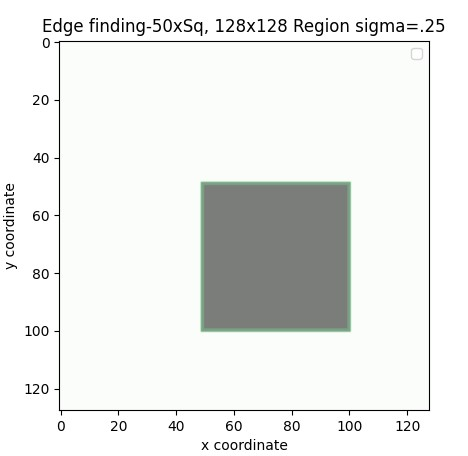
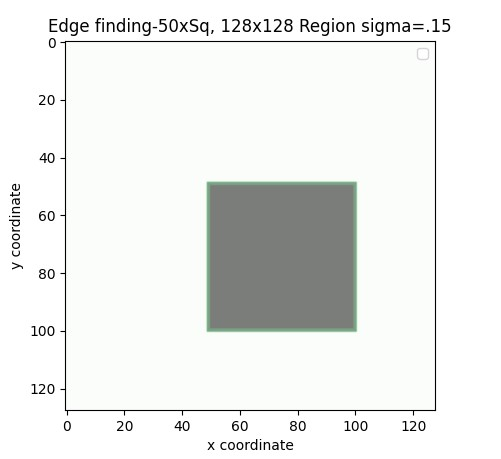

Using the gaussian laplacian filter with a sigma value of 0.1 gave no masking but the 

In [ ]:
search=distxy*abovePhi*radialClose
s=search>0

xx=x_coord*s
yy=y_coord*s

xy=numpy.unique(numpy.column_stack((xx,yy)),axis=0)

This current method does not care if duplicate vertices are sitting on one another in the "flattened" image

![Screenshot 2023-07-02 195631.jpg](<attachment:Screenshot 2023-07-02 195631.jpg>) ![Screenshot 2023-07-02 195612.jpg](<attachment:Screenshot 2023-07-02 195612.jpg>)
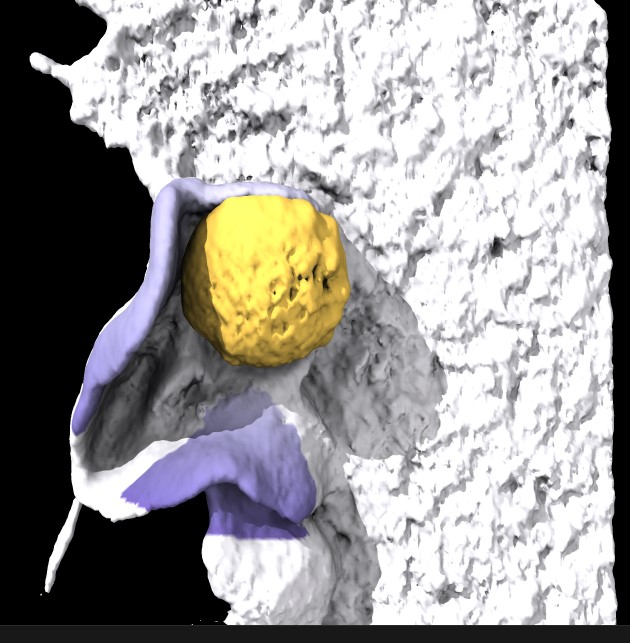
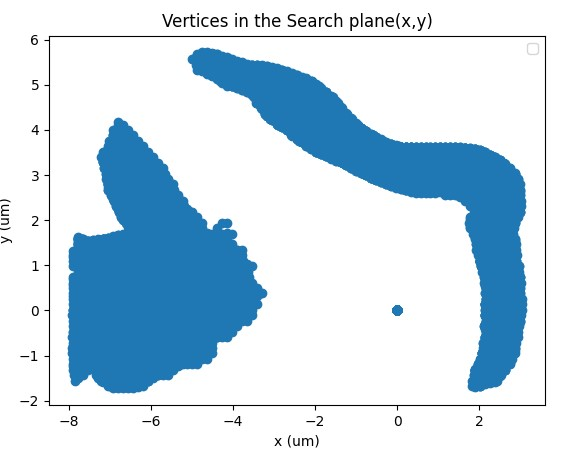

Attempts to solve for edges in the image failed where we get this super messed up output.

![Screenshot 2023-07-02 195934.jpg](<attachment:Screenshot 2023-07-02 195934.jpg>)
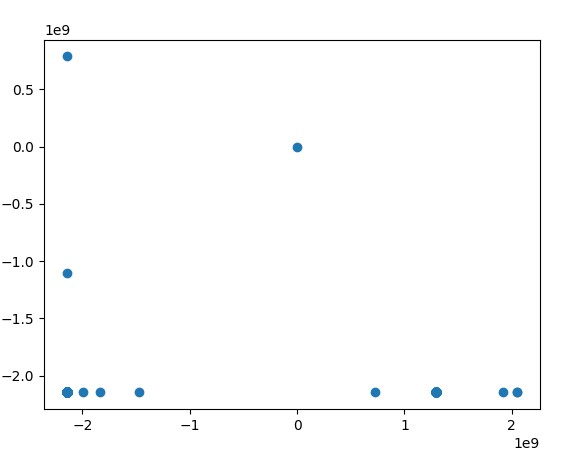

---Fresh attempt--
--Concept: I can bin vertice location along one axis (x-axis) via indexing in numpy. Then if I retain all unqiue positions per bin and sort the result I can bin all locations in the opposing axis (y-xis). This allows for a method to reconstruct the original pixel locations and should allow for the reconstruction of a 2D flattened matrix representing the 2D coverage for the search. From this artificial image I can simply sum all point corrosponding to the physical pixal size of the camera and output the search area to normalize our result. 

In [ ]:
"""Defining the pixel size from human defined parameter"""
width = size[1]
"""Defining steps that will are approximately one pixel in length"""
steps = numpy.int64(numpy.round_(numpy.abs((2*radius)/(width))))
"""Indexing the vertices that fall in one pixel of eachother along each axis""" 
xbins = numpy.digitize(xy[:,0],numpy.linspace(-8,8,steps))
ybins = numpy.digitize(xy[:,1],numpy.linspace(-8,8,steps))
"""Making an artificial binary image"""
ArtImg=numpy.zeros([steps,steps])
ArtImg[xbins,ybins]=1

plt.imshow(ArtImg, cmap='binary')
plt.title('Scatter plot of Artificial Image (x,y) values')
plt.xlabel('x um')
plt.ylabel('y um')
plt.show()

Outputs of vertice locations:

Object:

![Screenshot 2023-07-02 200259.jpg](<attachment:Screenshot 2023-07-02 200259.jpg>)

Vertice locations:

![Screenshot 2023-07-02 200312.jpg](<attachment:Screenshot 2023-07-02 200312.jpg>)

XY locations:

![Screenshot 2023-07-02 200538.jpg](<attachment:Screenshot 2023-07-02 200538.jpg>)
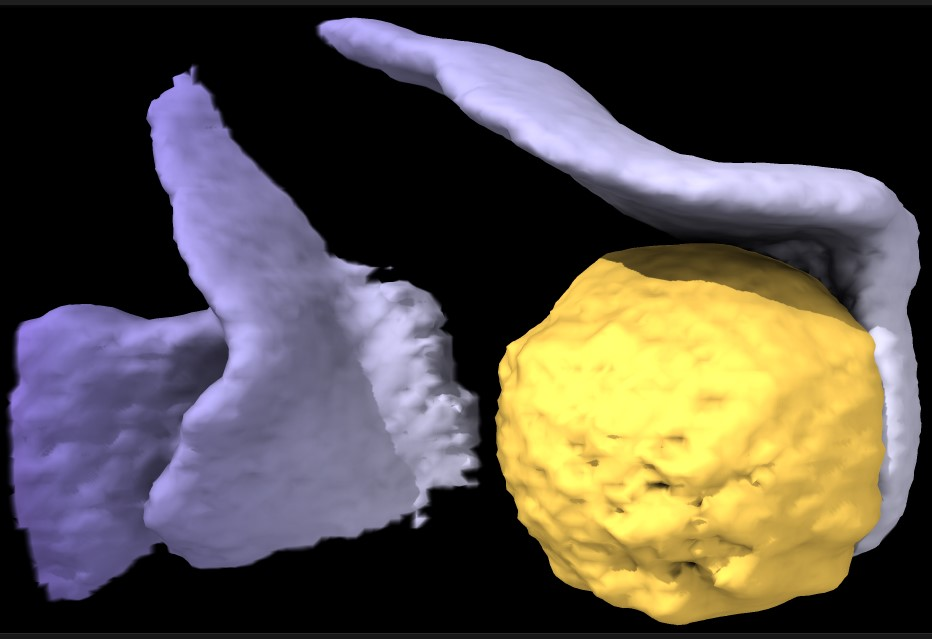
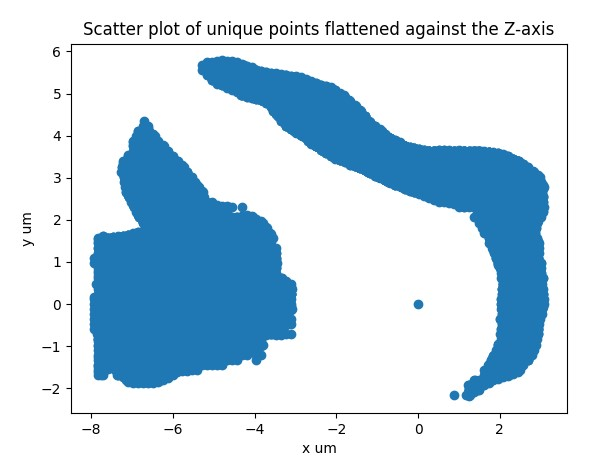
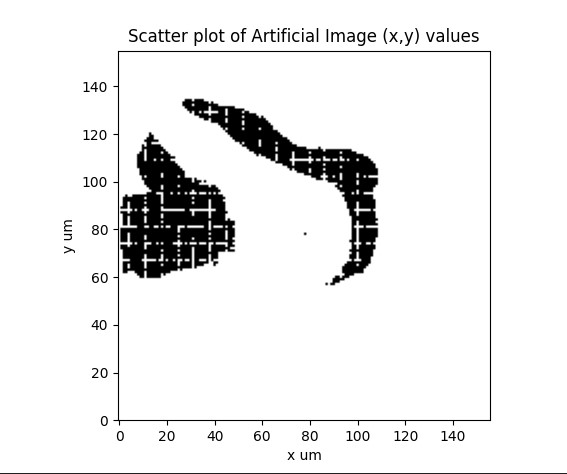

Data being plotted in the artificial image is the vertices and there is no guarantee these points will always line up with the true values since ChimeraX determination for smoothing and supersampling likely modulates these values slightly.

Impression:
    -this is a 16 micron scare that corolates to the search area (2d plane fo the 3d hemisphere)
    -Center is documented at ~80 pixels 
    -extra dot in the center is an artifact from the 
        -search=distxy*abovePhi*radialClose
        -s=search>0

        -xx=x_coord*s
        -yy=y_coord*s

        -xy=numpy.unique(numpy.column_stack((xx,yy)),axis=0)
        
        -Setting things not in the search to 0 results in a (x,y) (0,0) center point. If -i set to nan value this can fix this artifact.
    

Gaussian blures and  erodes to make the artificial image.

In [ ]:
glerode=scipy.ndimage.binary_erosion(((scipy.ndimage.gaussian_filter(ArtImg,.5))>0),border_value=1)
glerodes=scipy.ndimage.binary_erosion(((scipy.ndimage.gaussian_filter(ArtImg,.5))>0),border_value=1,iterations=2)

Light green is the reconstructed image, while the dark green is theindividual pixels from our vertice location.

![Screenshot 2023-07-02 200811.jpg](<attachment:Screenshot 2023-07-02 200811.jpg>) ![Screenshot 2023-07-02 200728.jpg](<attachment:Screenshot 2023-07-02 200728.jpg>) ![Screenshot 2023-07-02 200749.jpg](<attachment:Screenshot 2023-07-02 200749.jpg>) ![Screenshot 2023-07-02 201227.jpg](<attachment:Screenshot 2023-07-02 201227.jpg>)
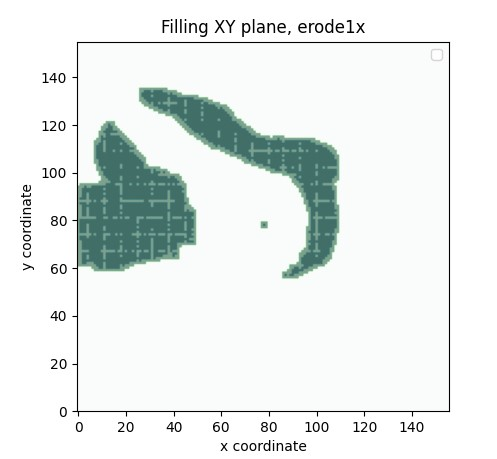
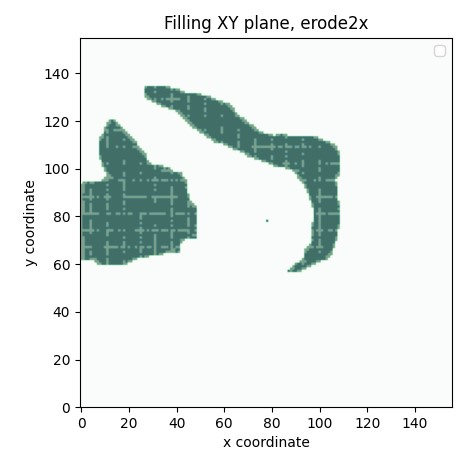
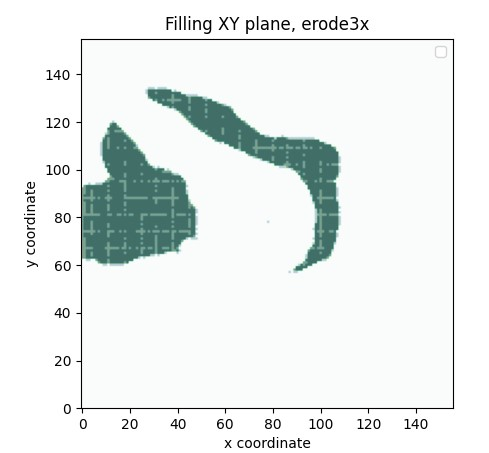
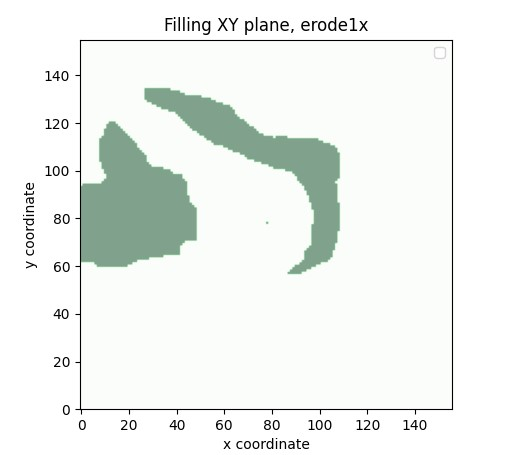

In [ ]:
numpy.count_nonzero(glerode)
Out[223]: 4027

numpy.count_nonzero(glerodes)
Out[224]: 3607

numpy.sum(glerode)*(0.1028**2)
Out[227]: 42.55669168

numpy.sum(glerodes)*(0.1028**2)
Out[228]: 38.11819888

numpy.sum(glerodess)*(0.1028**2)
Out[233]: 33.89106288

In [ ]:
Area_Search=numpy.count_nonzero(scipy.ndimage.binary_erosion(((scipy.ndimage.gaussian_filter(ArtImg,.5))>0),border_value=1,iterations=3)) * (size[1]**2)

Area_Search
Out[239]: 33.89106288

Area_Search=numpy.count_nonzero(scipy.ndimage.binary_erosion(((scipy.ndimage.gaussian_filter(ArtImg,.5))>0),border_value=1,iterations=3)) * (size[1]*size[1])

Area_Search
Out[241]: 33.89106288

Result: Here I show a simple method to ensure that we can output the surfaace area of objects using ther vertice postions. From the logic that the visual graph depicts the x,y plane of the objects found in our ChimeraX session we can infere the surface area output (in um^2) is close to the true value.
